In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
import unidecode
from spanish_nlp import preprocess

In [3]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [47]:
ciuo_df = pd.read_csv("data_in/ciuo08_v8.csv",encoding='utf-8',index_col=0)
#ciuo_df = pd.read_csv("ciuo08_v8.csv",encoding='utf-8',index_col=0)
ciuo_df.dropna(inplace=True)
ciuo_df = ciuo_df.drop(ciuo_df[ciuo_df.clase1 == 999].index)
ciuo_df = ciuo_df.drop(ciuo_df[ciuo_df.clase == 999].index)

# Obtén la lista de etiquetas únicas
labels_unique = ciuo_df['clase1'].unique()

# Crea columnas binarias para cada etiqueta única
for label in labels_unique:
    # Crea una columna con el nombre de la etiqueta (puedes personalizar el nombre)
    ciuo_df[f'clase{label}_b'] = (ciuo_df['clase1'] == label).astype(int)

# Elimina la columna original de etiquetas si es necesario
ciuo_df.drop(columns=['clase'], inplace=True)
ciuo_df.drop(columns=['clase1'], inplace=True)
ciuo_df.drop(columns=['text_id'], inplace=True)

In [48]:
ciuo_df

,texto,clase2_b,clase5_b,clase7_b,clase3_b,clase4_b,clase8_b,clase1_b,clase9_b,clase10_b,clase6_b
0,enfermero clinico atencion directas pacientes ...,1,0,0,0,0,0,0,0,0,0
1,enfermera clinica administracion atencion dire...,1,0,0,0,0,0,0,0,0,0
2,profesora ed fisica realizar clases ed fisica ...,1,0,0,0,0,0,0,0,0,0
3,cuidadora niño baña cuida comida niño años,0,1,0,0,0,0,0,0,0,0
4,vendedores almacen vende compra mercaderia,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69634,operador de linea matanza de salmones para aba...,0,0,0,0,0,0,0,1,0,0
69635,assora de inversiones asesorias a clientes t...,0,0,0,1,0,0,0,0,0,0
69636,quimico farmacia realiza fabricacion de pro...,1,0,0,0,0,0,0,0,0,0
69637,"operario agricola opera tractor, recogedora ...",0,0,0,0,0,1,0,0,0,0


In [4]:
sp = preprocess.SpanishPreprocess(
        lower=True,
        remove_url=True,
        remove_hashtags=False,
        split_hashtags=False,
        normalize_breaklines=True,
        remove_emoticons=False,
        remove_emojis=False,
        convert_emoticons=False,
        convert_emojis=False,
        normalize_inclusive_language=False,
        reduce_spam=False,
        remove_reduplications=False,
        remove_vowels_accents=True,
        remove_multiple_spaces=True,
        remove_punctuation=True,
        remove_unprintable=True,
        remove_numbers=True,
        remove_stopwords=True,
        stopwords_list='default',
        lemmatize=False,
        stem=False,
        remove_html_tags=True,
)

In [5]:
ciuo_df['texto'] = ciuo_df['texto'].apply(lambda texto: sp.transform(texto, debug = False))
ciuo_df['list'] = ciuo_df[ciuo_df.columns[1:]].values.tolist()

In [6]:
new_df = ciuo_df[['texto', 'list']].copy()
new_df.sample(10)

,texto,list
21610,guardia seguridad cuida protege empresa noviciado,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
8436,soldador calificado metal indust solda estruct...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
31648,operador agua potable entrega estados cuenta d...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
61403,bodeguero,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
3230,maestro constructor casas atender clientes con...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
26365,oficila marino mercante realizar tramites admi...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
48691,soldador al arco,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
30113,matrona directora cesfam cargo personal funcio...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
37575,analista sistema,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
61016,asesora del hogar,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


In [35]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 128
EPOCHS = 3
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es')

In [28]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texto = dataframe.texto
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.texto)

    def __getitem__(self, index):
        texto = str(self.texto[index])
        texto = " ".join(texto.split())

        inputs = self.tokenizer.encode_plus(
            texto,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [36]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (69415, 2)
TRAIN Dataset: (55532, 2)
TEST Dataset: (13883, 2)


In [40]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [31]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es')
        #self.l1 = transformers.BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
        self.l2 = torch.nn.Dropout(0.05)
        self.l3 = torch.nn.Linear(768, 128)
        self.l4 = torch.nn.LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        self.l5 = torch.nn.Dropout(0.05)
        self.l6 = torch.nn.Linear(128, 10)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, return_dict=False)
        output_2 = self.l2(output_1)
        output_3 = self.l3(output_2)
        output_4 = self.l4(output_3)
        output_5 = self.l5(output_4)
        output = self.l6(output_5)
        return output

In [32]:
model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [39]:
def validation():
    model.load_state_dict(torch.load('models/BERT_ciuo_1d.pth',map_location=torch.device('cpu')))
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [41]:
outputs, targets = validation()

Accuracy Score = 0.8143052654325434
F1 Score (Micro) = 0.8335235010489896
F1 Score (Macro) = 0.8143448899941881


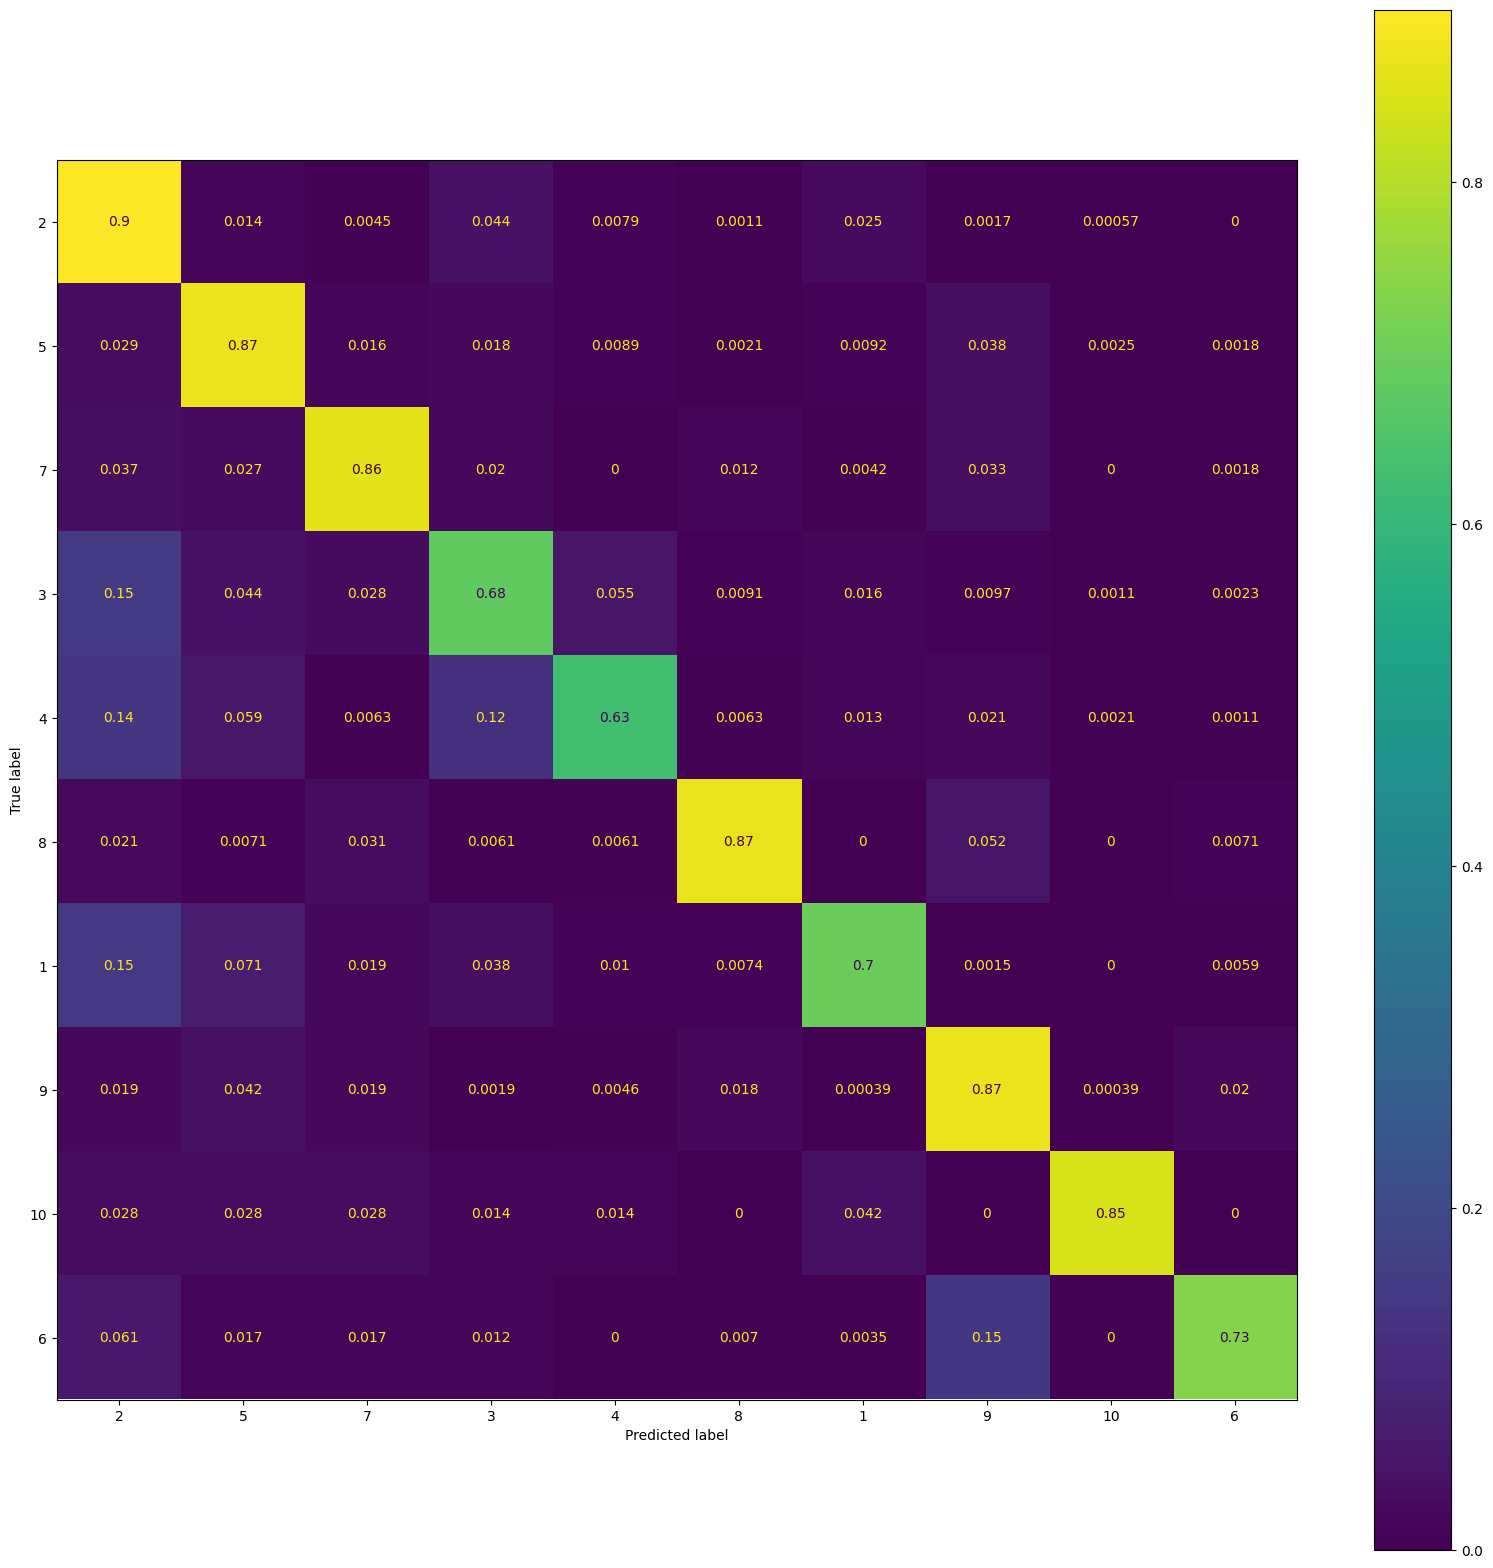

In [42]:
outputs = np.array(outputs) >= 0.5 # Aca debería ir el argmax
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
cm = confusion_matrix(np.argmax(targets, axis= 1), np.argmax(outputs, axis= 1))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels_unique[:41])
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_unique)
fig, ax = plt.subplots(figsize=(20, 20))
disp_normalized.plot(ax=ax)

print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



([<matplotlib.axis.XTick at 0x7c2da785eb30>,
 [Text(0, 0, '22.0'),
  Text(1, 0, '23.0'),
  Text(2, 0, '53.0'),
  Text(3, 0, '52.0'),
  Text(4, 0, '24.0'),
  Text(5, 0, '71.0'),
  Text(6, 0, '75.0'),
  Text(7, 0, '32.0'),
  Text(8, 0, '54.0'),
  Text(9, 0, '72.0'),
  Text(10, 0, '42.0'),
  Text(11, 0, '33.0'),
  Text(12, 0, '43.0'),
  Text(13, 0, '74.0'),
  Text(14, 0, '31.0'),
  Text(15, 0, '81.0'),
  Text(16, 0, '14.0'),
  Text(17, 0, '91.0'),
  Text(18, 0, '83.0'),
  Text(19, 0, '73.0'),
  Text(20, 0, '41.0'),
  Text(21, 0, '96.0'),
  Text(22, 0, '95.0'),
  Text(23, 0, '21.0'),
  Text(24, 0, '35.0'),
  Text(25, 0, '51.0'),
  Text(26, 0, '92.0'),
  Text(27, 0, '93.0'),
  Text(28, 0, '26.0'),
  Text(29, 0, '12.0'),
  Text(30, 0, '25.0'),
  Text(31, 0, '13.0'),
  Text(32, 0, '44.0'),
  Text(33, 0, '11.0'),
  Text(34, 0, '34.0'),
  Text(35, 0, '94.0'),
  Text(36, 0, '101.0'),
  Text(37, 0, '36.0'),
  Text(38, 0, '82.0'),
  Text(39, 0, '61.0'),
  Text(40, 0, '62.0'),
  Text(41, 0, '63.0')

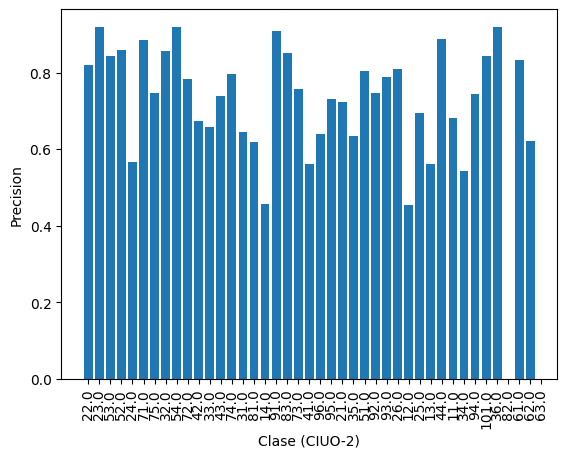

In [78]:
import plotly.express as px
import matplotlib.pyplot as plt
precision = metrics.precision_score(np.argmax(targets, axis= 1), outputs, average=None)
ordered_labels_unique = list(range(len(labels_unique)))
plt.bar(ordered_labels_unique[:41],precision)
plt.xlabel('Clase (CIUO-2)')
plt.ylabel('Precision')
plt.xticks(ordered_labels_unique, labels_unique,rotation=90)

([<matplotlib.axis.XTick at 0x7c2da785e200>,
 [Text(0, 0, '22.0'),
  Text(1, 0, '23.0'),
  Text(2, 0, '53.0'),
  Text(3, 0, '52.0'),
  Text(4, 0, '24.0'),
  Text(5, 0, '71.0'),
  Text(6, 0, '75.0'),
  Text(7, 0, '32.0'),
  Text(8, 0, '54.0'),
  Text(9, 0, '72.0'),
  Text(10, 0, '42.0'),
  Text(11, 0, '33.0'),
  Text(12, 0, '43.0'),
  Text(13, 0, '74.0'),
  Text(14, 0, '31.0'),
  Text(15, 0, '81.0'),
  Text(16, 0, '14.0'),
  Text(17, 0, '91.0'),
  Text(18, 0, '83.0'),
  Text(19, 0, '73.0'),
  Text(20, 0, '41.0'),
  Text(21, 0, '96.0'),
  Text(22, 0, '95.0'),
  Text(23, 0, '21.0'),
  Text(24, 0, '35.0'),
  Text(25, 0, '51.0'),
  Text(26, 0, '92.0'),
  Text(27, 0, '93.0'),
  Text(28, 0, '26.0'),
  Text(29, 0, '12.0'),
  Text(30, 0, '25.0'),
  Text(31, 0, '13.0'),
  Text(32, 0, '44.0'),
  Text(33, 0, '11.0'),
  Text(34, 0, '34.0'),
  Text(35, 0, '94.0'),
  Text(36, 0, '101.0'),
  Text(37, 0, '36.0'),
  Text(38, 0, '82.0'),
  Text(39, 0, '61.0'),
  Text(40, 0, '62.0'),
  Text(41, 0, '63.0')

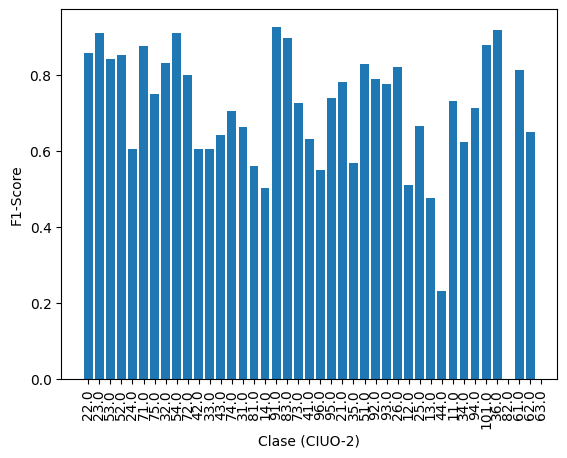

In [79]:
import plotly.express as px
import matplotlib.pyplot as plt
precision = metrics.f1_score(np.argmax(targets, axis= 1), outputs, average=None)
ordered_labels_unique = list(range(len(labels_unique)))
plt.bar(ordered_labels_unique[:41],precision)
plt.xlabel('Clase (CIUO-2)')
plt.ylabel('F1-Score')
plt.xticks(ordered_labels_unique, labels_unique,rotation=90)